In [24]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import pickle
from sklearn import tree


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.Config(fmt_str_lengths=1000)

dataset = pd.read_csv('dataset/train.csv')

In [25]:
# пример target кодирования
pl_dataset = pl.read_csv('dataset/train.csv')
pl_dataset = pl_dataset[:100]

region_encoder = pl.read_csv('dataset/region_encoder.csv')

def get_region(region):
    region = region.split(' ')[0]
    new_value = region_encoder.filter(pl.col('region') == region)['value'][0]
    return new_value

pl_dataset = pl_dataset.with_columns(pl.col('region')
                                        .map_elements(lambda x: get_region(x), return_dtype=pl.Float64)
                                        .alias('new_region'))

pl_dataset = pl_dataset[["region", "new_region"]]
with pl.Config(fmt_str_lengths=1000):
    print(pl_dataset.head(10))

shape: (10, 2)
┌───────────────────┬────────────┐
│ region            ┆ new_region │
│ ---               ┆ ---        │
│ str               ┆ f64        │
╞═══════════════════╪════════════╡
│ САМАРСКАЯ ОБЛ     ┆ 0.013007   │
│ ЛИПЕЦКАЯ ОБЛ      ┆ 0.021548   │
│ ОРЛОВСКАЯ ОБЛ     ┆ 0.008846   │
│ СВЕРДЛОВСКАЯ ОБЛ  ┆ 0.016141   │
│ ЛИПЕЦКАЯ ОБЛ      ┆ 0.021548   │
│ НИЖЕГОРОДСКАЯ ОБЛ ┆ 0.01085    │
│ ЛИПЕЦКАЯ ОБЛ      ┆ 0.021548   │
│ КРАСНОЯРСКИЙ КРАЙ ┆ 0.031437   │
│ УДМУРТСКАЯ РЕСП   ┆ 0.025441   │
│ ЛИПЕЦКАЯ ОБЛ      ┆ 0.021548   │
└───────────────────┴────────────┘


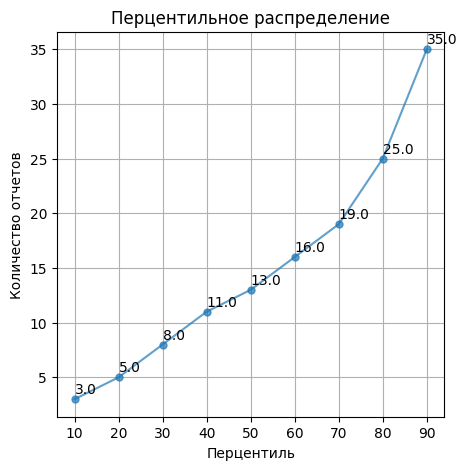

In [26]:
# перцентильное распределение
lag_per_id = np.array(dataset['npo_account_id'].value_counts())
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]
lag_percentiles = list()
for i in range(len(percentiles)):
    lag_percentiles.append(np.percentile(lag_per_id, percentiles[i]))

plt.figure(figsize=(5,5))
plt.plot(percentiles, lag_percentiles, marker='o', markersize=5, alpha=0.7)
for i in range(len(percentiles)):
    plt.text(percentiles[i], lag_percentiles[i]+0.5, lag_percentiles[i])
plt.xlabel('Перцентиль')
plt.ylabel('Количество отчетов')
plt.title('Перцентильное распределение')
plt.grid(True)
plt.savefig('foo.png')
plt.show()

In [ ]:
# графики
x = np.arange(0.001, 0.999, 0.001)
def func_gini(q):
    return 4 * q *(1 - q)

def func_entropy(q):
    return -q*np.log2(q)-(1-q)*np.log2(1-q)

gini = np.array(list(map(func_gini, x)))
entropy = np.array(list(map(func_entropy, x)))
plt.figure(figsize=(5,5))
plt.plot(x, gini, label='Индекс Джини')
plt.plot(x, entropy, label='Энтропия')
plt.xlabel('q')
plt.legend()
plt.show()

In [28]:
# анализ датасета
dataset_prepared = np.load('dataset_train_prepared.npy')
pd.DataFrame({'target': dataset_prepared[:, 257:258].ravel()}).describe()

,target
count,145144.00000
mean,0.20467
std,0.40346
min,0.00000
25%,0.00000
50%,0.00000
75%,0.00000
max,1.00000


In [29]:
# анализ тренировочного и тестового датасетов
from sklearn.model_selection import train_test_split
dataset_prepared = np.load('dataset_train_prepared.npy')
dataset_X = dataset_prepared[:, :257]
dataset_y = dataset_prepared[:, 257:258].ravel()
seed = 52
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=0.1, random_state=seed)
df1 = pd.DataFrame({'target_train': y_train}).describe()
df1['target_test'] = pd.DataFrame({'target_test': y_test}).describe()
df1

,target_train,target_test
count,130629.00000,14515.00000
mean,0.20548,0.19738
std,0.40406,0.39804
min,0.00000,0.00000
25%,0.00000,0.00000
50%,0.00000,0.00000
75%,0.00000,0.00000
max,1.00000,1.00000


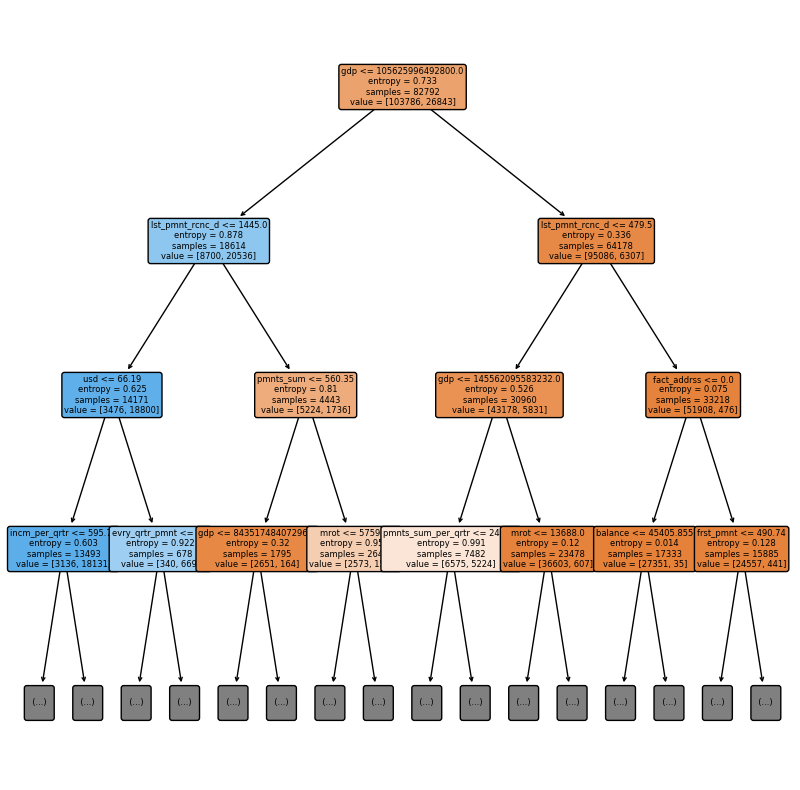

In [32]:
cb_model = pickle.load(open('models/cb_model.pkl', 'rb'))
rf_model = pickle.load(open('models/rf_model.pkl', 'rb'))

# визуализация дерева
feature_names = ['pmnts_type', 'quarter', 'gender', 'age', 'clnt_cprtn_time_d', 'actv_prd_d', 'lst_pmnt_rcnc_d', 'balance', 'oprtn_sum_per_qrtr', 'frst_pmnt', 'lst_pmnt', 'pmnts_sum', 'pmnts_nmbr', 'pmnts_sum_per_qrtr', 'pmnts_nmbr_per_qrtr', 'incm_sum', 'incm_per_qrtr', 'mgd_accum_period', 'mgd_payment_period', 'phone_number', 'email', 'lk', 'assignee_npo', 'assignee_ops', 'region', 'citizen', 'fact_addrss', 'appl_mrkr', 'evry_qrtr_pmnt', 'mrot', 'gdp', 'usd',
 'pmnts_type', 'quarter', 'gender', 'age', 'clnt_cprtn_time_d', 'actv_prd_d', 'lst_pmnt_rcnc_d', 'balance', 'oprtn_sum_per_qrtr', 'frst_pmnt', 'lst_pmnt', 'pmnts_sum', 'pmnts_nmbr', 'pmnts_sum_per_qrtr', 'pmnts_nmbr_per_qrtr', 'incm_sum', 'incm_per_qrtr', 'mgd_accum_period', 'mgd_payment_period', 'phone_number', 'email', 'lk', 'assignee_npo', 'assignee_ops', 'region', 'citizen', 'fact_addrss', 'appl_mrkr', 'evry_qrtr_pmnt', 'mrot', 'gdp', 'usd',
 'pmnts_type', 'quarter', 'gender', 'age', 'clnt_cprtn_time_d', 'actv_prd_d', 'lst_pmnt_rcnc_d', 'balance', 'oprtn_sum_per_qrtr', 'frst_pmnt', 'lst_pmnt', 'pmnts_sum', 'pmnts_nmbr', 'pmnts_sum_per_qrtr', 'pmnts_nmbr_per_qrtr', 'incm_sum', 'incm_per_qrtr', 'mgd_accum_period', 'mgd_payment_period', 'phone_number', 'email', 'lk', 'assignee_npo', 'assignee_ops', 'region', 'citizen', 'fact_addrss', 'appl_mrkr', 'evry_qrtr_pmnt', 'mrot', 'gdp', 'usd',
 'pmnts_type', 'quarter', 'gender', 'age', 'clnt_cprtn_time_d', 'actv_prd_d', 'lst_pmnt_rcnc_d', 'balance', 'oprtn_sum_per_qrtr', 'frst_pmnt', 'lst_pmnt', 'pmnts_sum', 'pmnts_nmbr', 'pmnts_sum_per_qrtr', 'pmnts_nmbr_per_qrtr', 'incm_sum', 'incm_per_qrtr', 'mgd_accum_period', 'mgd_payment_period', 'phone_number', 'email', 'lk', 'assignee_npo', 'assignee_ops', 'region', 'citizen', 'fact_addrss', 'appl_mrkr', 'evry_qrtr_pmnt', 'mrot', 'gdp', 'usd',
 'pmnts_type', 'quarter', 'gender', 'age', 'clnt_cprtn_time_d', 'actv_prd_d', 'lst_pmnt_rcnc_d', 'balance', 'oprtn_sum_per_qrtr', 'frst_pmnt', 'lst_pmnt', 'pmnts_sum', 'pmnts_nmbr', 'pmnts_sum_per_qrtr', 'pmnts_nmbr_per_qrtr', 'incm_sum', 'incm_per_qrtr', 'mgd_accum_period', 'mgd_payment_period', 'phone_number', 'email', 'lk', 'assignee_npo', 'assignee_ops', 'region', 'citizen', 'fact_addrss', 'appl_mrkr', 'evry_qrtr_pmnt', 'mrot', 'gdp', 'usd',
 'pmnts_type', 'quarter', 'gender', 'age', 'clnt_cprtn_time_d', 'actv_prd_d', 'lst_pmnt_rcnc_d', 'balance', 'oprtn_sum_per_qrtr', 'frst_pmnt', 'lst_pmnt', 'pmnts_sum', 'pmnts_nmbr', 'pmnts_sum_per_qrtr', 'pmnts_nmbr_per_qrtr', 'incm_sum', 'incm_per_qrtr', 'mgd_accum_period', 'mgd_payment_period', 'phone_number', 'email', 'lk', 'assignee_npo', 'assignee_ops', 'region', 'citizen', 'fact_addrss', 'appl_mrkr', 'evry_qrtr_pmnt', 'mrot', 'gdp', 'usd',
 'pmnts_type', 'quarter', 'gender', 'age', 'clnt_cprtn_time_d', 'actv_prd_d', 'lst_pmnt_rcnc_d', 'balance', 'oprtn_sum_per_qrtr', 'frst_pmnt', 'lst_pmnt', 'pmnts_sum', 'pmnts_nmbr', 'pmnts_sum_per_qrtr', 'pmnts_nmbr_per_qrtr', 'incm_sum', 'incm_per_qrtr', 'mgd_accum_period', 'mgd_payment_period', 'phone_number', 'email', 'lk', 'assignee_npo', 'assignee_ops', 'region', 'citizen', 'fact_addrss', 'appl_mrkr', 'evry_qrtr_pmnt', 'mrot', 'gdp', 'usd',
 'pmnts_type', 'quarter', 'gender', 'age', 'clnt_cprtn_time_d', 'actv_prd_d', 'lst_pmnt_rcnc_d', 'balance', 'oprtn_sum_per_qrtr', 'frst_pmnt', 'lst_pmnt', 'pmnts_sum', 'pmnts_nmbr', 'pmnts_sum_per_qrtr', 'pmnts_nmbr_per_qrtr', 'incm_sum', 'incm_per_qrtr', 'mgd_accum_period', 'mgd_payment_period', 'phone_number', 'email', 'lk', 'assignee_npo', 'assignee_ops', 'region', 'citizen', 'fact_addrss', 'appl_mrkr', 'evry_qrtr_pmnt', 'mrot', 'gdp', 'usd',
 'pens']
tree_in_rf = rf_model.estimators_[4]


plt.figure(figsize=(10,10))
tree.plot_tree(tree_in_rf, max_depth=3, feature_names=feature_names, filled=True, rounded=True, fontsize=6)
plt.savefig('example_tree', dpi=100)
plt.show()

In [33]:
# важность параметров rm
features = rf_model.feature_importances_
df = pd.DataFrame({'feature_names': feature_names, 'features': features})
df = df.groupby('feature_names').sum().sort_values('features', ascending=False)
df

,features
feature_names,
gdp,0.19138
mrot,0.18479
usd,0.14491
lst_pmnt_rcnc_d,0.10679
pmnts_sum_per_qrtr,0.04821
oprtn_sum_per_qrtr,0.04270
age,0.02583
pmnts_nmbr_per_qrtr,0.02232
balance,0.02197


In [34]:
# важность параметров cb
features = cb_model.feature_importances_
df = pd.DataFrame({'feature_names': feature_names, 'features': features})
df = df.groupby('feature_names').sum().sort_values('features', ascending=False)
df

,features
feature_names,
mrot,24.89051
gdp,23.15146
usd,9.74489
mgd_payment_period,7.34763
mgd_accum_period,5.54175
lst_pmnt_rcnc_d,4.50939
quarter,3.28562
oprtn_sum_per_qrtr,2.99414
fact_addrss,2.18216
